## 特征重要度
目前常用的机器学习集成模型特征重要度方法如下：
* XGBoost
> weight（权重）
>
> gain（增益）
>
> cover（覆盖）

* LightGBM
> split（分裂）
>
> gain（增益）

* 随机森林
> 平均准确率的减少（mean decrease accuracy），常用袋外误差率去衡量
>
> 平均不纯度的减少（mean decrease impurity）,常用 gini 或 entropy

* GBDT
> 平均不纯度的减少（mean decrease impurity）

## XGBoost
>XGBoost 库中的 get_score 方法可通过 importance_type 参数选择 'weight', 'gain', 'cover', 'total_gain', 'total_cover' 五种特征重要度方法，其中 $$gain=\frac{total\_gain}{weight},cover=\frac{total\_cover}{weight}$$
>
>在 sklearn 的调用方法中，将特征重要度的选择封装在 XGBClassifier 、XGBRegressor 的入参中（默认gain），训练完模型后用 feature_importances_ 查看重要度（在get_score结果基础上归一化）

In [1]:
'''建立一颗深度为3的XGBoost'''
import numpy as np
import xgboost as xgb

sample_num = 10
feature_num = 2

np.random.seed(0)
data = np.random.randn(sample_num, feature_num)
np.random.seed(0)
label = np.random.randint(0, 2, sample_num)

train_data = xgb.DMatrix(data, label=label)
params = {'max_depth': 3}
bst = xgb.train(params, train_data, num_boost_round=1)

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'f0': 1, 'f1': 2}
gain:  {'f0': 0.265151441, 'f1': 0.375000015}
cover:  {'f0': 10.0, 'f1': 4.0}
total_gain:  {'f0': 0.265151441, 'f1': 0.75000003}
total_cover:  {'f0': 10.0, 'f1': 8.0}


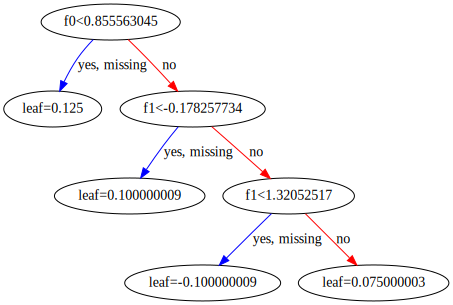

In [2]:
xgb.to_graphviz(bst, num_trees=0)

In [3]:
trees = bst.get_dump(with_stats=True)

importance_type += '='
fmap = {}
gmap = {}
for tree in trees:
    for line in tree.split('\n'):
        print(line)

0:[f0<0.855563045] yes=1,no=2,missing=1,gain=0.265151441,cover=10
	1:leaf=0.125,cover=5
	2:[f1<-0.178257734] yes=3,no=4,missing=3,gain=0.354166687,cover=5
		3:leaf=0.100000009,cover=2
		4:[f1<1.32052517] yes=5,no=6,missing=5,gain=0.395833343,cover=3
			5:leaf=-0.100000009,cover=2
			6:leaf=0.075000003,cover=1



* weight（权重）：特征被选为分裂特征的次数，作为分割节点个数和
> 可以看到f0被作为1次分裂特征，f1被作为2次，weight表示的特征重要度分别为1、2
* total_gain（增益）：特征作为分裂特征后带来的总增益
> 该增益为XGBoost树分支的参考因素，gain表示的特征重要度分别为0.265151441、0.375000015
> 
> $$gain=\frac{1}{2}[\frac{{G}^2_L}{(H_L+\lambda)}+\frac{{G}^2_R}{(H_R+\lambda)}-\frac{{{G}_L+{G}_R}^2}{(H_L+H_R+\lambda)}]$$
* gain（平均增益）：特征作为分裂特征后带来的平均增益
* total_cover（覆盖）：特征作为分裂特征后对样本的总覆盖率（经过该特征的样本数）
> 首先在第1个节点（f0作为分裂特征），该节点有10个样本经过，在第2个节点（f1作为分裂特征）有5个样本经过，在第2个节点（f1作为分裂特征）有3个样本经过，cover表示的特征重要度分别为10、8
* gain（平均覆盖）：特征作为分裂特征后对样本平均覆盖率

## LightGBM
>lightgbm 库中的 feature_importance 方法可通过 importance_type 参数选择 'split', 'gain' 两种特征重要度方法
>
>在 sklearn 的调用方法中，将特征重要度的选择封装在 LGBMClassifier 、LGBMRegressor 的入参中（默认split，在特征选择中建议用gain），训练完模型后用 feature_importances_ 查看重要度（未归一化，与xgboost库不同）

In [4]:
'''建立一颗深度为3的LightGBM'''
import lightgbm as lgb

sample_num = 10
feature_num = 2

np.random.seed(0)
data = np.random.randn(sample_num, feature_num)
np.random.seed(0)
label = np.random.randint(0, 2, sample_num)

np.random.seed(0)
x_train = np.random.random((100,2))
np.random.seed(0)
y_train = np.random.randint(0, 2, 100)

lgb_train = lgb.Dataset(x_train, y_train)

params = {
    'max_depth': 3,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1)

for importance_type in ('split', 'gain'):
    print('%s: ' % importance_type, gbm.feature_importance(importance_type=importance_type))

split:  [2 1]
gain:  [1.65164  0.217778]


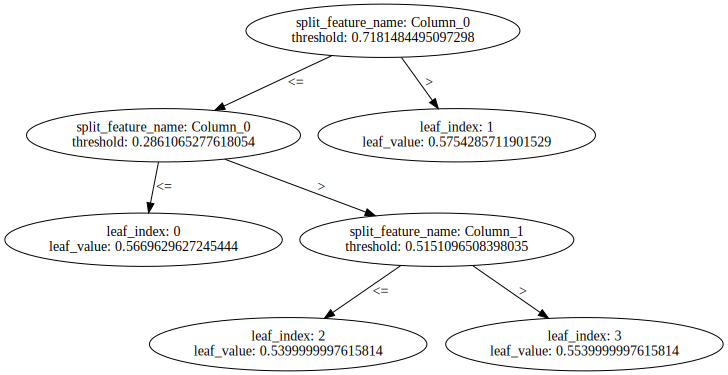

In [5]:
lgb.create_tree_digraph(gbm)

* split（分裂）：特征被选为分裂特征的次数，作为分割节点个数和，与xgboost的weight相同
> 可以看到Column_0被作为2次分裂特征，Column_1被作为1次，weight表示的特征重要度分别为2、1
* gain（增益）：特征作为分裂特征后带来的总增益
> 该增益为LightGBM树分支的参考因素（与XGBoost不同，在[LightGBM源码阅读+理论分析](https://blog.csdn.net/weixin_42001089/article/details/85343332)有介绍LightGBM增益（熵）的计算，gain表示的特征重要度分别为1.65164、0.217778

## 随机森林
> sklearn库中，训练完模型可用 feature_importtances_ 查看重要度，随机森林在sklearn使用的特征重要度方法只有平均不纯度的减少（mean decrease impurity），但在平均不纯度的计算上有两种分别是 gini（基尼指数） 和 entropy（信息熵），基于单颗决策树，基尼指数与信息熵详情见[“熵”与“基尼不纯度”同为判断混乱程度的标准](https://blog.csdn.net/weixin_38100489/article/details/79334061)
>
> 将特征重要度的选择封装在 RandomForestClassifier 、RandomForestRegressor 的分裂标准（criterion）入参中（默认gini），因分裂标准不同训练的模型不同，训练完模型后用 feature_importances_ 查看重要度（归一化）

## GBDT
> sklearn库中，训练完模型可用 feature_importtances_ 查看重要度，随机森林在sklearn使用的特征重要度方法只有平均不纯度的减少（mean decrease impurity），平均不纯度使用的是 分裂之后平方损失的减少值（未证实），出自[Tree ensemble算法的特征重要度计算](https://yangxudong.github.io/tree-ensemble-importance/)，基于单颗决策树
>
> sklearn库GradientBoostingClassifier、GradientBoostingRegressor 的特征重要度无其他方法，训练完模型后用 feature_importances_ 查看重要度（归一化）